In [2]:
import httpx
import mlcroissant as mlc
import pandas as pd
import numpy as np
from matplotlib import pyplot as pyplot
import matplotlib.ticker as mticker
import seaborn as sns
import math

from pathlib import Path

In [3]:
# CONSTANTS
PARENT_FOLDER = Path.cwd()
DATA_FOLDER = PARENT_FOLDER / "data"
DATASET_URL = (
    "https://www.kaggle.com/datasets/CooperUnion/cardataset/croissant/download"
)

In [4]:
def download_data(url: str):
    dataset = mlc.Dataset(url)

    return dataset

car_dataset = download_data(DATASET_URL)
car_record_sets = car_dataset.metadata.record_sets
dataset_uuid = car_record_sets[0].uuid
car_records = car_dataset.records(dataset_uuid)



  -  [Metadata(Car Features and MSRP)] Property "http://mlcommons.org/croissant/citeAs" is recommended, but does not exist.


In [5]:
df_car_raw = pd.DataFrame(car_records)
len(df_car_raw)

df_car = df_car_raw.copy(deep=True)

In [6]:
# Clean column names
df_car.columns = df_car.columns.str.lower().str.replace("+", "_").str.replace("data.csv/", "")
df_car.columns


Index(['make', 'model', 'year', 'engine_fuel_type', 'engine_hp',
       'engine_cylinders', 'transmission_type', 'driven_wheels',
       'number_of_doors', 'market_category', 'vehicle_size', 'vehicle_style',
       'highway_mpg', 'city_mpg', 'popularity', 'msrp'],
      dtype='object')

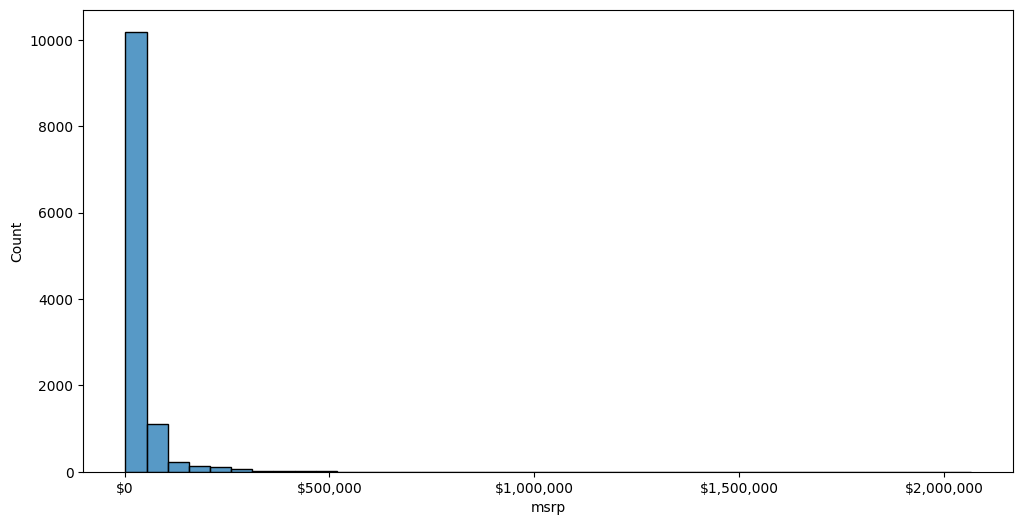

In [7]:
# plot the distribution of our target variable, the msrp

pyplot.rcParams["figure.figsize"] = (12, 6)

ax = sns.histplot(data=df_car, x="msrp", bins=40)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${int(x):,}'))

In [ ]:
# Apply a simple log transformation to even out the distribution of the data
# df_car["msrp_normalized"] = df_car["msrp"].apply(
#     lambda x: math.log(x + 1)
# )

df_car["msrp_normalized"] = np.log1p(df_car.msrp)

df_car[["msrp", "msrp_normalized"]]


,msrp,msrp_normalized
0,46135,10.739349
1,40650,10.612779
2,36350,10.500977
3,29450,10.290483
4,34500,10.448744
...,...,...
11909,46120,10.739024
11910,56670,10.945018
11911,50620,10.832122
11912,50920,10.838031


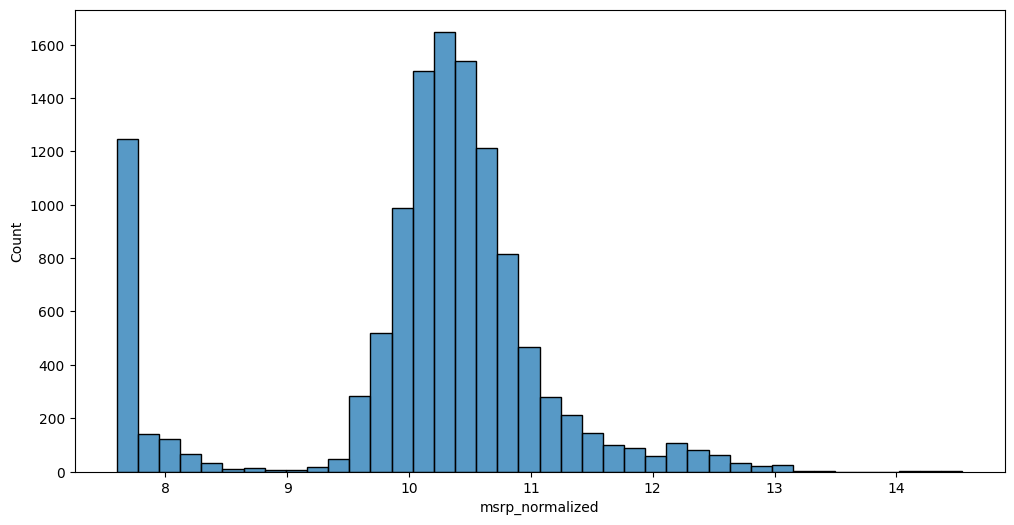

In [10]:
ax = sns.histplot(data=df_car, x="msrp_normalized", bins=40)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

In [ ]:
# Check missing values to improve our training data
#  for our potential features
df_car.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
msrp_normalized         0
dtype: int64

In [18]:
# Splitting data sets (validation, test, training)

# calculate the indices
n_total = len(df_car)
n_validation = int(0.2 * n_total) # ~20% of the total data
n_test = int(0.2 * n_total) # ~20% of the total data
n_training = n_total - (n_validation + n_test) # remaining ~60%

# get the random shuffling of data
np.random.seed(25) # for reproducibility
idx = np.arange(n_total)
np.random.shuffle(idx)

# create the shuffled datasets
df_shuffled = df_car.iloc[idx]
df_training = df_shuffled.iloc[:n_training].copy() # from 0-index but before n_training index
df_validation = df_shuffled.iloc[n_training:(n_training + n_validation)].copy() # from n_training index up to (n_training + n_validation) rows
df_test = df_shuffled.iloc[(n_training + n_validation):].copy() # start from the `to` index from above to the rest of the rows. This is the remaining data

df_test

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp,msrp_normalized
795,b'Volvo',b'850',1997,b'regular unleaded',190.0,5.0,b'AUTOMATIC',b'front wheel drive',4.0,"b'Luxury,Performance'",b'Midsize',b'Wagon',24,18,870,2000,7.601402
1588,b'Toyota',b'Avalon Hybrid',2015,b'regular unleaded',200.0,4.0,b'AUTOMATIC',b'front wheel drive',4.0,b'Hybrid',b'Midsize',b'Sedan',39,40,2031,36470,10.504273
2533,b'Honda',b'Civic CRX',1991,b'regular unleaded',62.0,4.0,b'MANUAL',b'front wheel drive',2.0,b'Hatchback',b'Compact',b'2dr Hatchback',44,36,2202,2000,7.601402
3468,b'Dodge',b'Dakota',2009,b'regular unleaded',210.0,6.0,b'AUTOMATIC',b'rear wheel drive',4.0,b'Flex Fuel',b'Compact',b'Extended Cab Pickup',20,15,1851,22560,10.023978
9958,b'Dodge',b'SRT Viper',2014,b'premium unleaded (required)',640.0,10.0,b'MANUAL',b'rear wheel drive',2.0,"b'Exotic,High-Performance'",b'Compact',b'Coupe',19,12,1851,107385,11.584185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8447,b'Buick',b'Regal',2016,b'premium unleaded (recommended)',259.0,4.0,b'AUTOMATIC',b'front wheel drive',4.0,b'Performance',b'Midsize',b'Sedan',30,21,155,34065,10.436055
2934,b'Toyota',b'Corolla',2015,b'regular unleaded',140.0,4.0,b'AUTOMATIC',b'front wheel drive',4.0,None,b'Compact',b'Sedan',40,30,2031,22725,10.031265
10383,b'Ford',b'Thunderbird',2005,b'premium unleaded (required)',280.0,8.0,b'AUTOMATIC',b'rear wheel drive',2.0,b'Performance',b'Midsize',b'Convertible',22,16,5657,38355,10.554666
6618,b'BMW',b'M6 Gran Coupe',2016,b'premium unleaded (required)',552.0,8.0,b'AUTOMATED_MANUAL',b'rear wheel drive',4.0,"b'Factory Tuner,Luxury,High-Performance'",b'Large',b'Sedan',20,14,3916,117200,11.671646


In [ ]:
# apply distribution normalization with log1p to remove long tail
y_training = np.log1p(df_training["msrp"])
y_validation = np.log1p(df_validation["msrp"])
y_test = np.log1p(df_validation["msrp"])

# remove the target variable to prevent us from accidentally using it
df_training = df_training.drop(columns=["msrp"])
df_validation = df_validation.drop(columns=["msrp"])
df_test = df_test.drop(columns=["msrp"])